In [164]:
import torch
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))


threshold = 1e-9
max_iter = 1000
learning_rate = 0.03

radius = 3.0
origin=torch.tensor([5.0, 5.0], device=device)
side_length=4.0

sdf = 'circle'
#sdf = 'box'


destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3090


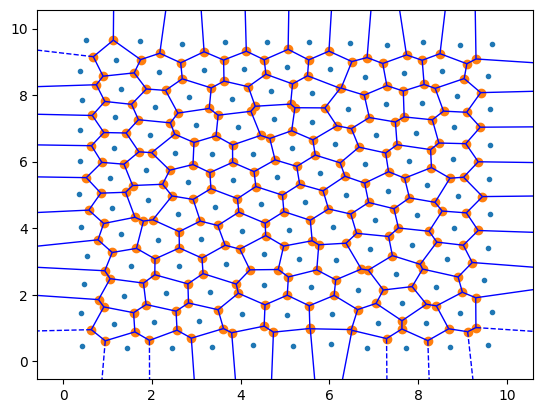

In [165]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
vor = Voronoi(centroids*10)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='blue')
# Plot the points
plt.savefig('CVT_'f'{num_centroids}''.png',transparent=True)
plt.show()


In [166]:
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)


#torch.manual_seed(30)
#sites = torch.rand(11, 2, dtype=torch.float32,device=device, requires_grad=True)

#sites = sites * 10.0
print(sites)


tensor([[8.1052, 9.5934],
        [2.5985, 4.4357],
        [7.9818, 4.4041],
        [3.3168, 2.0778],
        [1.1816, 9.0396],
        [6.0012, 8.7985],
        [7.6266, 1.7632],
        [1.1487, 1.1294],
        [7.0590, 6.7998],
        [8.7840, 6.0669],
        [0.4112, 4.0501],
        [5.4515, 4.7782],
        [3.3482, 6.2378],
        [9.6612, 1.4707],
        [5.1737, 0.4683],
        [6.4561, 9.5498],
        [2.6820, 9.5334],
        [1.8645, 5.7545],
        [2.1294, 3.6608],
        [1.9537, 6.8015],
        [5.3111, 3.0861],
        [9.5787, 8.5857],
        [3.0555, 1.2123],
        [5.1630, 6.4016],
        [9.5740, 3.4205],
        [8.7184, 0.4359],
        [7.3078, 5.1279],
        [8.0747, 7.7492],
        [9.6217, 6.4997],
        [3.0040, 7.0977],
        [0.4778, 2.3384],
        [6.9029, 3.3667],
        [0.5206, 9.6403],
        [6.8523, 0.4046],
        [3.1727, 8.7569],
        [4.0239, 3.9292],
        [0.4172, 7.8532],
        [6.1352, 6.5158],
        [2.0

In [167]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [168]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [169]:
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [170]:
def circle_sdf_loss(vertices, radius=1.0, origin=torch.tensor([0.0, 0.0])):
    # Calculate the Euclidean distance of each vertex to the specified origin
    distances = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex
    
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    return sdf_values


In [ ]:
def zerocrossing_optim(neighbors, sites):
    filtered_triplets = compute_vertices_index(neighbors)

    # List to store unique pairs of neighboring triplets with zero-crossing SDF values
    sdf_filtered_triplets = []
    # Set to track unique triplets that have already been added
    seen_triplets = set()
    
    for i in range(len(filtered_triplets)):
        count = 0
        triplet_a = set(filtered_triplets[i])
        
        for j in range(i + 1, len(filtered_triplets)):
            triplet_b = set(filtered_triplets[j])
            if count == 3:
                break
            if len(triplet_a.intersection(triplet_b)) == 2:
                vertices = [
                    compute_vertex(sites[filtered_triplets[i][0]], sites[filtered_triplets[i][1]], sites[filtered_triplets[i][2]]),
                    compute_vertex(sites[filtered_triplets[j][0]], sites[filtered_triplets[j][1]], sites[filtered_triplets[j][2]])
                ]
                vertices = torch.stack(vertices)
                
                sdf_ab = circle_sdf_loss(vertices, radius=radius, origin=origin)
                
                if sdf_ab[0] * sdf_ab[1] < 0:
                    count += 1
                    triplet_a_tuple = tuple(sorted(filtered_triplets[i]))
                    triplet_b_tuple = tuple(sorted(filtered_triplets[j]))
                    
                    if triplet_a_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[i])
                        seen_triplets.add(triplet_a_tuple)
                        
                    if triplet_b_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[j])
                        seen_triplets.add(triplet_b_tuple)

    return sdf_filtered_triplets


In [173]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [174]:
def box_sdf_loss(vertices, side_length=4.0):
    # Calculate half side length (since box is centered at origin)
    half_side = side_length / 2.0
    
    # Compute the signed distance to the box for each vertex
    dx = torch.clamp(torch.abs(vertices[:, 0]) - half_side, min=0)  # Distance from x-axis bounds
    dy = torch.clamp(torch.abs(vertices[:, 1]) - half_side, min=0)  # Distance from y-axis bounds
    
    # Calculate the SDF as the Euclidean distance from the nearest box boundary
    sdf_values = torch.sqrt(dx**2 + dy**2)
    return sdf_values


In [175]:
def min_distance_regularization(sites):
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.sum(penalties**2)
    
    return regularization_loss



In [176]:
def create_dynamic_mask(sdf_values):
    # Calculate the mean and standard deviation of the SDF values
    mean_sdf = sdf_values.mean()
    std_sdf = sdf_values.std()
    
    # Define a dynamic threshold based on the mean and standard deviation
    # For example, consider vertices within one standard deviation of the mean
    lower_threshold = mean_sdf - std_sdf
    upper_threshold = mean_sdf + std_sdf
    
    # Create a mask where SDF values fall within the dynamic range
    mask = (sdf_values > lower_threshold) & (sdf_values < upper_threshold)
    
    return mask.float()  # Convert boolean mask to float for further use


In [ ]:
def autograd(sites, learning_rate=learning_rate, max_iter=max_iter, threshold=threshold, radius=radius):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    
    for epoch in range(max_iter):
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        #vertices_to_compute = compute_vertices_index(neighbors)
        vertices_to_compute = zerocrossing_optim(neighbors, sites)
        
        vertices = compute_all_vertices(sites,vertices_to_compute)
                
        if sdf == 'circle':
            sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        elif sdf == 'box':
            sdf_values = box_sdf_loss(vertices)
        
        #sdf_mask = create_dynamic_mask(sdf_values)
        #masked_loss = (sdf_values ** 2 * sdf_mask).sum() / sdf_mask.sum()  # Normalize by the number of selected vertices
        
        
        
        # regularization loss        
        min_distance_loss = min_distance_regularization(sites)
        
        # Total loss
        #loss = masked_loss + min_distance_loss
        loss = torch.mean(sdf_values**2) + min_distance_loss

        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(vertices_to_compute)
        if abs(prev_loss - loss.item()) < threshold:
            break
        prev_loss = loss.item()
        
    return sites

In [178]:
def plot_sdf(ax):
    #plot the sdf function
    if sdf == 'circle':
        circle = plt.Circle(origin.detach().cpu().numpy(), radius, color='black', fill=False)
        ax.add_artist(circle)
    elif sdf == 'box':
        rect = plt.Rectangle((5, 5), side_length, side_length/2, fill=False, color='black')
        ax.add_artist(rect)

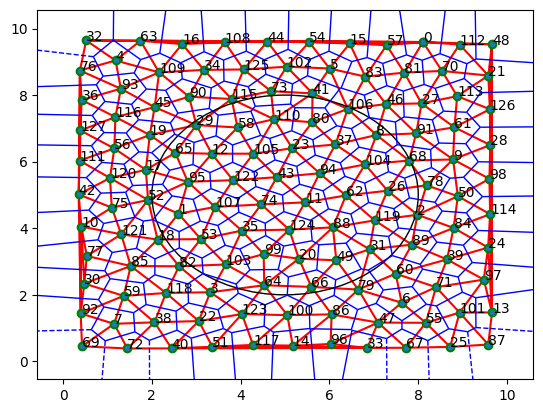

In [179]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)

#scaled plot
#plt.xlim(-4,4)
#plt.ylim(-4,4)

plt.savefig(f'{destination}multiple_initial.png')

plt.show()

In [180]:
autograd(sites)

Epoch 0: loss = 0.4368141722218893
[[18, 1, 52], [18, 1, 53], [52, 1, 95], [78, 2, 50], [78, 2, 26], [84, 2, 89], [119, 2, 89], [64, 3, 103], [64, 3, 123], [103, 3, 82], [82, 3, 118], [41, 5, 106], [106, 41, 80], [79, 6, 60], [79, 31, 60], [68, 8, 91], [46, 8, 91], [68, 9, 91], [37, 8, 106], [106, 8, 46], [68, 9, 78], [68, 26, 78], [65, 12, 29], [65, 19, 29], [65, 17, 19], [65, 17, 95], [52, 17, 120], [52, 17, 95], [82, 18, 85], [82, 18, 53], [64, 20, 66], [66, 64, 100], [58, 29, 115], [115, 29, 90], [89, 31, 60], [119, 31, 89], [102, 41, 73], [73, 41, 110], [66, 49, 79], [79, 66, 86], [110, 73, 115], [115, 73, 125]]
Epoch 100: loss = 0.0340989585051474
[[18, 1, 52], [18, 1, 53], [52, 1, 95], [82, 18, 53], [52, 17, 95], [78, 2, 26], [119, 2, 26], [68, 26, 78], [119, 2, 31], [60, 2, 31], [49, 31, 60], [64, 3, 103], [99, 64, 103], [103, 3, 82], [103, 53, 82], [104, 8, 91], [46, 8, 91], [106, 8, 46], [106, 46, 83], [68, 9, 78], [68, 9, 61], [68, 61, 104], [65, 12, 19], [19, 12, 29], [65, 

tensor([[ 8.4633,  9.1702],
        [ 2.7782,  3.5054],
        [ 7.2808,  4.0993],
        [ 3.1570,  2.4744],
        [ 1.1962,  9.3763],
        [ 6.1415,  7.9644],
        [ 7.5466,  2.8969],
        [ 1.3077,  0.8970],
        [ 7.0652,  6.9840],
        [ 7.8240,  6.2481],
        [ 1.8239,  3.8834],
        [ 4.5606,  2.5620],
        [ 2.7046,  6.4680],
        [ 9.2545,  1.4765],
        [ 5.0677,  1.5530],
        [ 6.0397,  7.6864],
        [ 3.5563,  8.6000],
        [ 1.8092,  5.2309],
        [ 2.5679,  3.8640],
        [ 2.4253,  6.5669],
        [ 4.8607,  1.7672],
        [ 9.5700,  8.6887],
        [ 4.4645,  1.8019],
        [ 4.1547,  7.6115],
        [ 9.1610,  3.0375],
        [ 8.4873, -0.1996],
        [ 8.1840,  5.3123],
        [ 7.5703,  6.0888],
        [ 8.1570,  5.9375],
        [ 3.5680,  7.1650],
        [ 0.7546,  2.9751],
        [ 6.0023,  2.9141],
        [ 0.9023,  9.3769],
        [ 6.3108,  1.8281],
        [ 3.6359,  8.3153],
        [ 3.0695,  3

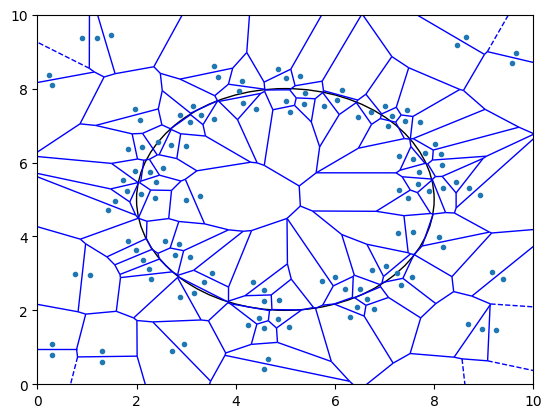

In [181]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
# plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
# plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')
# 
# annotate the points with their index
# for i, txt in enumerate(range(len(sites_np))):
#     ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)
plt.xlim(0,10)
plt.ylim(0,10)


plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

plt.show()